# Introduction

A short notebook where we explore hair removal techniques on dermatoscopic images

## Import libraries

In [1]:
# Basic libraries
import os
import warnings
import cv2
from tqdm import tqdm 
import random


import matplotlib.pyplot as plt

## Load data

In [2]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [3]:
INPUT_FOLDER = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/sample_images/jpg/"
OUTPUT_FOLDER = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/sample_images/cleaned/"
RESIZED_FOLDER = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/sample_images/resized/"

In [4]:
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(RESIZED_FOLDER, exist_ok=True)

# Util functions

In [5]:
def resize_and_save_images(input_folder, resized_folder, image_size=(256, 256)):
    """
    Resize images and save them in a separate folder.
    """
    os.makedirs(resized_folder, exist_ok=True)  # Ensure resized folder exists
    file_list = os.listdir(input_folder)  # Get all files in the folder

    for file_name in tqdm(file_list, desc="Resizing Images", unit="file"):
        image_path = os.path.join(input_folder, file_name)
        image = cv2.imread(image_path)

        if image is None:
            continue

        # Resize image
        resized_image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)

        # Save resized image
        resized_path = os.path.join(resized_folder, file_name)
        cv2.imwrite(resized_path, resized_image)

    print("✅ Resizing Complete! Resized images saved in:", resized_folder)


In [6]:
def show_images_in_line(folder_path, num_images=5, image_width=100, image_height=100):
    """
    Displays images from a folder in a single row using Matplotlib.

    :param folder_path: Path to the folder containing images.
    :param num_images: Number of images to display.
    :param image_width: Width to resize each image.
    :param image_height: Height to resize each image.
    """
    # Get list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    # Limit to the desired number of images
    image_files = image_files[:num_images]

    if not image_files:
        print("No images found in the folder.")
        return

    fig, axes = plt.subplots(1, len(image_files), figsize=(len(image_files) * 3, 3))

    # If only one image, make axes a list for uniformity
    if len(image_files) == 1:
        axes = [axes]

    for ax, file in zip(axes, image_files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)  # Read image with OpenCV
        if img is None:
            continue  # Skip unreadable images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
        img = cv2.resize(img, (image_width, image_height))  # Resize for consistency
        ax.imshow(img)
        ax.set_title(file)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# SharpRazor

## How Sharp Razor works

### 🧼 apply_clahe(image)
- Purpose: Enhance image contrast, especially useful for dermoscopic images with low contrast or uneven illumination.

#### What it does:
- Converts the image from BGR to LAB color space — LAB separates lightness (L) from color information (A and B).
- Applies CLAHE (Contrast Limited Adaptive Histogram Equalization) on the L-channel to boost contrast locally.
- Merges the enhanced L with original A and B channels, then converts back to BGR.

This helps to make hair strands and lesion edges more distinguishable from the background, improving the quality of hair detection.

### 🕵️‍♂️ detect_hair(image)
Purpose: Detect hair strands in the image by creating a binary hair mask.

#### Step-by-step:
1. Converts the image to grayscale — hair is usually dark and linear, and grayscale simplifies detection
2. Applies a Black-Hat morphological operation with a 9x9 kernel.
    - Black-Hat = background - closing(image)
    - This emphasizes dark, thin structures (like hairs) on a lighter background.
3. Uses adaptive thresholding (cv2.threshold + Otsu) to create a binary mask of these dark lines.
4. Refines the mask using morphological closing with a 3x3 kernel and 2 iterations to:
    - Close small gaps in detected hairs.
    - Remove noise and make the mask more coherent.

Hair tends to be darker than skin, and black-hat + Otsu thresholding picks up that contrast effectively, while morphological cleanup ensures only the meaningful structures remain.



### 🧽 remove_hair(image, hair_mask)
Purpose: Actually removes the detected hair by inpainting the hair regions.

#### How:
- Uses OpenCV’s cv2.inpaint() with:
    - INPAINT_NS → Navier-Stokes based inpainting (good for smooth continuation of lines and texture).
    - inpaintRadius=5 → The radius around hair pixels used to reconstruct the missing info.

🎨 Result: The inpainting fills in the hair-covered regions using surrounding skin/lesion texture, giving a clean image without visible hair.

## Defining functions

In [14]:
def apply_clahe(image):
    """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for low-contrast images."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return enhanced_image


In [15]:
def detect_hair(image):
    """Detect hair using adaptive thresholding and morphological operations."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Black-Hat Morphological Operation to highlight hair
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))  # Adjust for different hair thickness
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    # Adaptive thresholding to create hair mask
    _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Use morphology to refine the hair mask (remove noise)
    kernel_refine = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    hair_mask = cv2.morphologyEx(hair_mask, cv2.MORPH_CLOSE, kernel_refine, iterations=2)
    hair_mask = cv2.erode(hair_mask, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1)), iterations=2)

    return hair_mask



In [16]:
def remove_hair(image, hair_mask):
    """Remove hair by inpainting detected areas using Navier-Stokes inpainting."""
    # result = cv2.inpaint(image, hair_mask, inpaintRadius=5, flags=cv2.INPAINT_NS)
    result = cv2.inpaint(image, hair_mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
    return result

In [10]:
def process_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists
    file_list = os.listdir(input_folder)  # Get all files in the folder

    for file_name in tqdm(file_list, desc="Processing Images", unit="file"):
        image_path = os.path.join(input_folder, file_name)
        image = cv2.imread(image_path)

        if image is None:
            continue

        # Process the resized image
        enhanced_image = apply_clahe(image)
        hair_mask = detect_hair(enhanced_image)
        clean_image = remove_hair(image, hair_mask)

        output_path = os.path.join(output_folder, file_name)
        cv2.imwrite(output_path, clean_image)  # Save processed image

    print("✅ Batch Processing Complete!")



## Processing and Evaluation

Processing Images: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.06file/s]


✅ Batch Processing Complete!


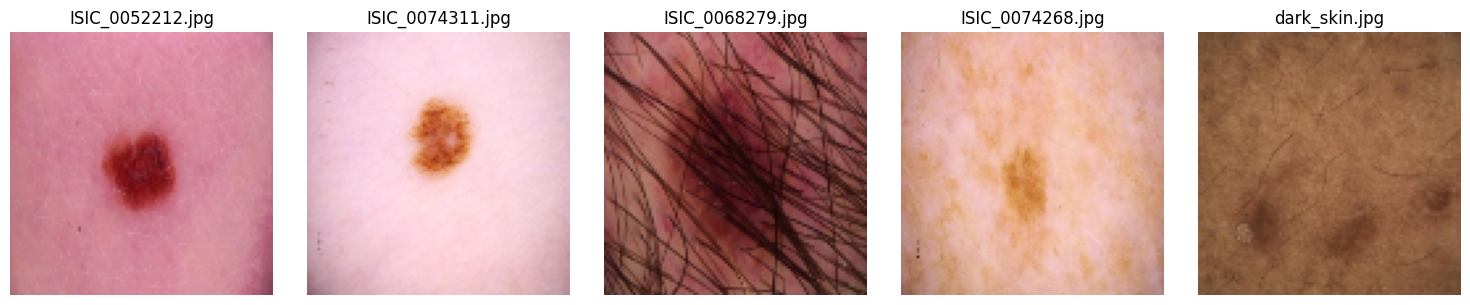

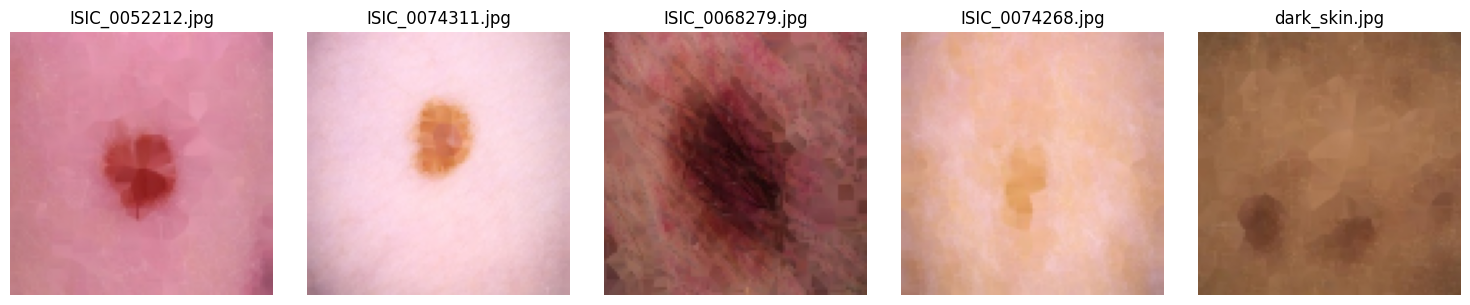

In [17]:
resize_and_save_images(INPUT_FOLDER, RESIZED_FOLDER, (224, 224))
process_folder(RESIZED_FOLDER, OUTPUT_FOLDER)
show_images_in_line(RESIZED_FOLDER)
show_images_in_line(OUTPUT_FOLDER)

## Conclusion

Very blurry. Does not do good job of removing hairs even after manual hyperparameter tuning

# Dull Razor - ol' faithful

Older algorithm, but more stable and reliable

## Defining fucntions

In [49]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 3 else img


In [48]:
def process_image(path, img_size):
    #Read image
    image=cv2.imread(path,cv2.IMREAD_COLOR)
    #Image cropping
    cropped_igm =image[30:410,30:560]
    #Image resizing
    resized_img=cv2.resize(image, (img_size,img_size))
    
    #Gray scale
    grayScale = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY )
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(resized_img,mask,6,cv2.INPAINT_TELEA)   

    return image, resized_img, grayScale, blackhat, mask, dst

    

In [50]:
def show_image(image, resized_img, grayScale, blackhat, mask, dst):
    images = [
        ("Original image", to_rgb(image)),
        ("Cropped image", to_rgb(resized_img)),
        ("Gray Scale image", grayScale),
        ("Blackhat", blackhat),
        ("Binary mask", mask),
        ("Clean image", to_rgb(dst)),
    ]
    
    # Plot in 2x3 grid
    plt.figure(figsize=(12, 8))
    for i, (title, img) in enumerate(images, 1):
        plt.subplot(2, 3, i)
        cmap = "gray" if len(img.shape) == 2 else None
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

## Processing and evaluation

In [52]:
path='/Users/mipopovic/Desktop/MunjeLumenDS2025/data/sample_images/jpg/2.jpg'
show_image(*(process_image(path, 224)))

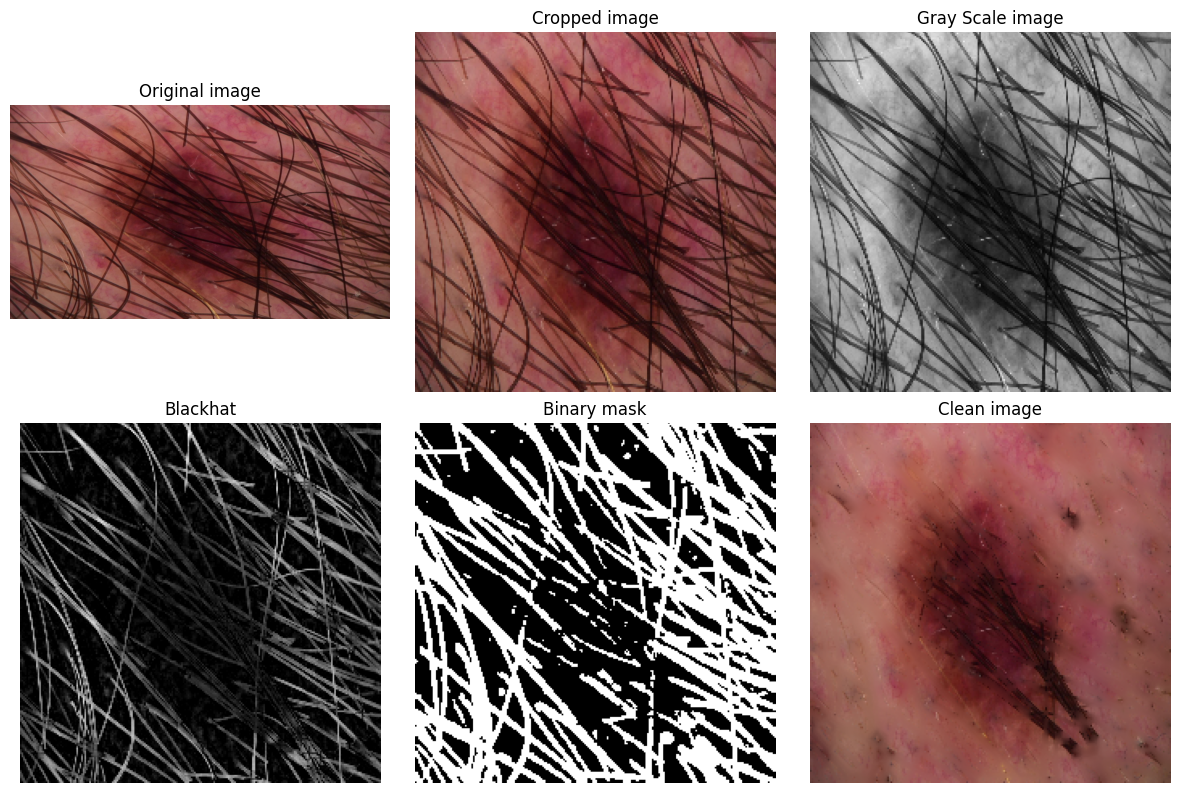

In [53]:
path='/Users/mipopovic/Desktop/MunjeLumenDS2025/data/sample_images/jpg/3.jpg'
show_image(*(process_image(path, 224)))

In [54]:
path='/Users/mipopovic/Desktop/MunjeLumenDS2025/data/sample_images/jpg/dark_skin.jpg'
show_image(*(process_image(path, 224)))

## Conclusion

Dull Razor works great! And it's computationaly simple than Sharp Razor! 

### TRIPLE BAM!!!